<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### DESAFÍO 2
Se intenta crear un bot que responda a reclamos de clientes de un delivery de comidas


### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
import json
import string
import random 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchsummary

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-07-28 11:24:44 INFO: Downloading default packages for language: es (Spanish)...
2023-07-28 11:24:50 INFO: File exists: D:\Users\juanp_schamun\stanza_resources\es\default.zip.
2023-07-28 11:24:57 INFO: Finished downloading models and saved to D:\Users\juanp_schamun\stanza_resources.
2023-07-28 11:25:00 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-07-28 11:25:00 INFO: Use device: cpu
2023-07-28 11:25:00 INFO: Loading: tokenize
2023-07-28 11:25:10 INFO: Loading: mwt
2023-07-28 11:25:11 INFO: Loading: pos
2023-07-28 11:25:12 INFO: Loading: lemma
2023-07-28 11:25:12 INFO: Loading: depparse
2023-07-28 11:25:12 INFO: Loading: ner
2023-07-28 11:25:14 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [43]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buenas"],
              "responses": ["Hola!", "Buenas", "¿Como te va?"],
             },
             {"tag": "ayuda",
              "patterns": ["Necesito ayuda?", "Tengo un problema", "¿Me haces un favor?", "¿Podrian ayudarme?"],
              "responses": ["Decime en que puedo ayudarte", "¿Cual es tu inconveniente?", "Si, decime..."]
             },
            {"tag": "Envio_demorado",
              "patterns": ["No me llego mi pedido", "Estoy esperando un envio", "Mi pedido esta demorado", "¿Cuando llega lo que pedi?"],
              "responses": ["Para revizar necesito el numero de envio", "Pasame el numero de envio, por favor"]
             },
            {"tag": "Producto_con_problemas",
              "patterns": ["Mi pedido llego en mal estado", "La comida esta fria", "Me faltan cosas en el paquete", "Faltan cosas en el envio"],
              "responses": ["Decime por favor el detalle de lo que te llego", "¿Que contiene el envio que recibiste?"]
             },
            {"tag": "Mal_trato",
              "patterns": ["Me trataron mal", "El chico me contesto mal", "Me insultaron"],
              "responses": ["¿Me podrias describir la situacion?", "¿Como fue?", "¿Que te dijeron?"]
             },
            {"tag": "mal_cobro",
              "patterns": ["Creo que me cobraron de mas", "No me dieron mi vuelto", "Me tienen que devolver dinero"],
              "responses": ["¿Que medio de pago utilizaste?", "¿Decime el numero de factura por favor?"]
             },            
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme", "No, gracias a vos!"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!", "Gracias por contactarnos"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [44]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [45]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['ayuda', 'ayudarmar', 'buen', 'chau', 'chico', 'cobrar', 'comida', 'como', 'contear', 'cosa', 'creer', 'cuando', 'dar', 'de', 'demorado', 'devolver', 'dinero', 'el', 'en', 'envio', 'esperar', 'estado', 'estar', 'este', 'faltar', 'favor', 'fria', 'gracias', 'hacer', 'hasta', 'holar', 'insultar', 'llegar', 'luego', 'mal', 'mas', 'mi', 'mucho', 'necesitar', 'no', 'paquete', 'pedido', 'pedir', 'poder', 'problema', 'que', 'tal', 'tener', 'tratar', 'uno', 'volver', 'yo', 'él']
classes: ['Envio_demorado', 'Mal_trato', 'Producto_con_problemas', 'agradecimientos', 'ayuda', 'bienvenida', 'despedida', 'mal_cobro']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Buenas', 'Necesito ayuda?', 'Tengo un problema', '¿Me haces un favor?', '¿Podrian ayudarme?', 'No me llego mi pedido', 'Estoy esperando un envio', 'Mi pedido esta demorado', '¿Cuando llega lo que pedi?', 'Mi pedido llego en mal estado', 'La comida esta fria', 'Me faltan cosas en el paquete', 'Faltan cosas en el envio', 'Me trataron m

In [46]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 53


In [47]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 8


In [48]:
classes

['Envio_demorado',
 'Mal_trato',
 'Producto_con_problemas',
 'agradecimientos',
 'ayuda',
 'bienvenida',
 'despedida',
 'mal_cobro']

In [49]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 53
Output dim 8


In [51]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

### 5 - Entrenamiento del modelo

In [52]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           6,912
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 8]             520
           Softmax-8                 [-1, 1, 8]               0
Total params: 15,688
Trainable params: 15,688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [53]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }
    
    return history

In [54]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 2.076 - Train accuracy 0.192
Epoch: 2/200 - Train loss 2.079 - Train accuracy 0.115
Epoch: 3/200 - Train loss 2.074 - Train accuracy 0.154
Epoch: 4/200 - Train loss 2.075 - Train accuracy 0.115
Epoch: 5/200 - Train loss 2.077 - Train accuracy 0.192
Epoch: 6/200 - Train loss 2.078 - Train accuracy 0.154
Epoch: 7/200 - Train loss 2.072 - Train accuracy 0.231
Epoch: 8/200 - Train loss 2.078 - Train accuracy 0.269
Epoch: 9/200 - Train loss 2.076 - Train accuracy 0.154
Epoch: 10/200 - Train loss 2.074 - Train accuracy 0.192
Epoch: 11/200 - Train loss 2.070 - Train accuracy 0.192
Epoch: 12/200 - Train loss 2.073 - Train accuracy 0.154
Epoch: 13/200 - Train loss 2.075 - Train accuracy 0.154
Epoch: 14/200 - Train loss 2.073 - Train accuracy 0.269
Epoch: 15/200 - Train loss 2.072 - Train accuracy 0.154
Epoch: 16/200 - Train loss 2.070 - Train accuracy 0.192
Epoch: 17/200 - Train loss 2.070 - Train accuracy 0.192
Epoch: 18/200 - Train loss 2.070 - Train accuracy 0.192
E

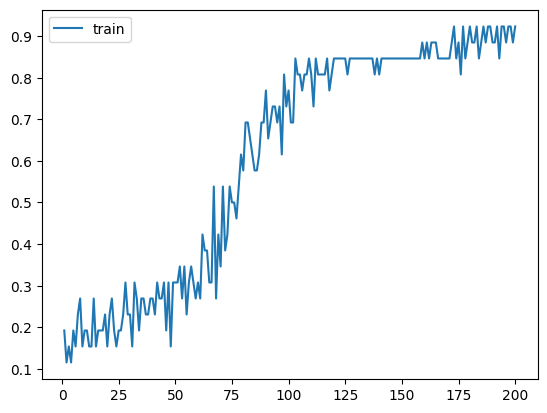

In [55]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

### 6 - Testing y validación

In [56]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [57]:
message = "Hola buenos dias"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset)
    print(result)

BOT: Buenas


In [58]:
abc = True
while abc == True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    if len(message) == 0:
        abc = False
    

BOT: Decime por favor el detalle de lo que te llego
BOT: Decime por favor el detalle de lo que te llego
BOT: Buenas
BOT: Hasta luego!
Perdón, no comprendo la pregunta.


### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes bien siempre y cuando las preguntas contengan las palabras que tenemos incoproradas
En algunos casos se ve que se enfrenta a ambigüedades y responde sobre otro tag al esperado.